# Model 2: Classification Algorithm

Classifies food crisis data based on world bank data (can be used for predictions)

In [18]:
# import libraries: standard env, +pysal, + jupyter, + matplotlib
#### import libraries ####
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
os.getcwd()

start = timeit.default_timer()

## 1. Read Data

In [19]:
# Read FS data
FS = pd.read_csv('Data/FS_data.csv')


## 2. Model Preprocessing

In [20]:
# Drop unnecessary columns (i.e. space/time no longer need because lags are accounted for)
data = FS.drop(['country', 'admin_code', 'admin_name', 'year_month', 'year', 'month', 'geometry'], axis=1)

**Addressing missing values**

 - If 25% of a columns data is NA, that column is removed
 - For all other missing values, the column mean is used - BUT need a better option!

In [21]:
# Establish how much data is missing
print(data.isnull().sum().sort_values(ascending=False).head())

# Find the columns with large amounts of na values
variables_na = []
for i in data:
    if data[i].isnull().sum() > 6900: # change this according to be 25% of df
        str(i)
        variables_na.append(i)
data = data.drop(columns=variables_na) #delete those

spacelag       3120
timelag2       1944
timelag1        972
area              0
pasture_pct       0
dtype: int64


In [22]:
# Impute the missing values using SimpleImputer in sklearn.impute
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(data)

data = pd.DataFrame(data=imp.transform(data), columns=data.columns)

# Check if there is still missing data
data.isnull().sum().sort_values(ascending=False).head()

centx          0
area           0
timelag1       0
spacelag       0
pasture_pct    0
dtype: int64

**Normalize the data set**
- Scales each column to values between 0-1 to be better interpreted by the models
- CHECK: how normalisation impacts model accuracy

In [23]:
fews_ipc = data['fews_ipc']
data = data.drop(['fews_ipc'], axis=1)
scaler = MinMaxScaler()
data = gpd.GeoDataFrame(scaler.fit_transform(data), columns=data.columns, index=FS.index)
data.head()
data.describe()
data['class'] = fews_ipc

**Add Binary Classification**
- Using column quartiles as a suitable threshold base
- CHECK: how classification complexity impacts models
- NOTE: Using +3 classes would be more informative in our model explorations

In [24]:
# Binary classification based on quartiles
# data['class'] = [0 if x == 1 else 1 for x in data['class']]
# data['class'] = data['class'].astype(float) # Reformat column


## 3. Random Forest Classification

In [25]:
# Load functions

# For plotting confusion matrix
def plot_confusion_matrix(train_pred, train, dom):
    classes = {'Food Security': 0, 'Food Insecurity': 1}
    cf = confusion_matrix(train_pred,train)
    sns.heatmap(cf,annot=True,yticklabels=classes,xticklabels=classes,cmap='Blues', fmt='g')
    plt.title(f'{dom} Confusion matrix')
    plt.tight_layout()
    plt.figure(figsize=(1, 2), dpi=80)
    plt.show()


**Randomly split data in training and testing sets**

In [26]:
# A. SPLIT TRAIN/TEST SETS
# Random 70% split in train and test sets (time series is accounted for by lags)
# split data into x & y
y = data['class']
x = data.drop(columns=['class'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

**Tune hyper-parameters**
* n_estimators = Number of trees in random forest
* max_features = Number of features to consider at every split
* max_depth = Maximum number of levels in tree
* min_samples_leaf = Minimum number of samples required at each leaf node
* min_samples_split = Minimum number of samples required to split a node
* bootstrap = Method of selecting samples for training each tree

Found: {'bootstrap': False,
 'max_depth': 72,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 72}

In [27]:
# param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [2, 5, 10],
#                'bootstrap': [True, False]}
#
# # Create a based model
# rf = RandomForestClassifier()
#
# # Instantiate the grid search model
# rf_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
# rf_Grid.fit(x_train,y_train)
#
# # Get best parameters
# rf_Grid.best_params_


**Fit Optimised Model**

In [28]:
# C. RESULTS
# Fit optimised model
clf=RandomForestClassifier(n_estimators=72, min_samples_leaf=2, min_samples_split=2,
                           max_features='sqrt', max_depth=72, bootstrap=False)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=72, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=72)

**Evaluate Model**

Ensemble Train Model Accuracy(in %): 99.98530276308054
Ensemble Test Model Accuracy(in %): 92.72976680384087


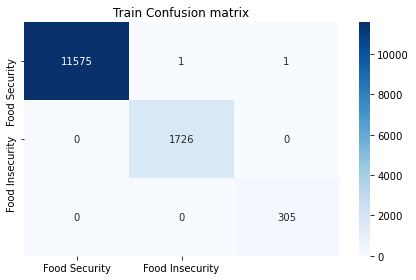

<Figure size 80x160 with 0 Axes>

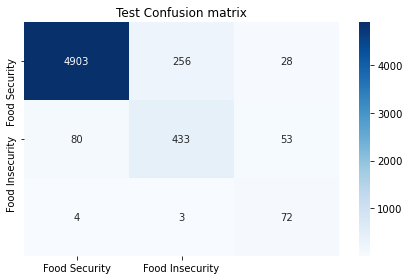

<Figure size 80x160 with 0 Axes>

In [29]:
# Evaluate performance
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
print(f'Ensemble Train Model Accuracy(in %): {metrics.accuracy_score(y_train_pred,y_train)*100}')
print(f'Ensemble Test Model Accuracy(in %): {metrics.accuracy_score(y_test_pred,y_test)*100}')
plot_confusion_matrix(y_train_pred,y_train,dom='Train')
plot_confusion_matrix(y_test_pred,y_test,dom='Test')


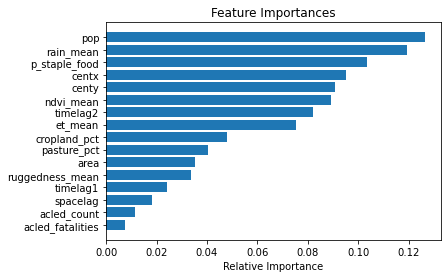

In [30]:
# Evaluate variable importance

# for name, importance in zip(x_test.columns, clf.feature_importances_):
#     print(name, "=", importance)

features = x_test.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center') # color
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [31]:
# Make individual prediction


stop = timeit.default_timer()
print('Running Time: ', stop - start, 'seconds')


Running Time:  15.20741709999993 seconds
